Cantidad de filas de entrenamiento:  379


  0%|          | 0/150000 [00:00<?, ?it/s]

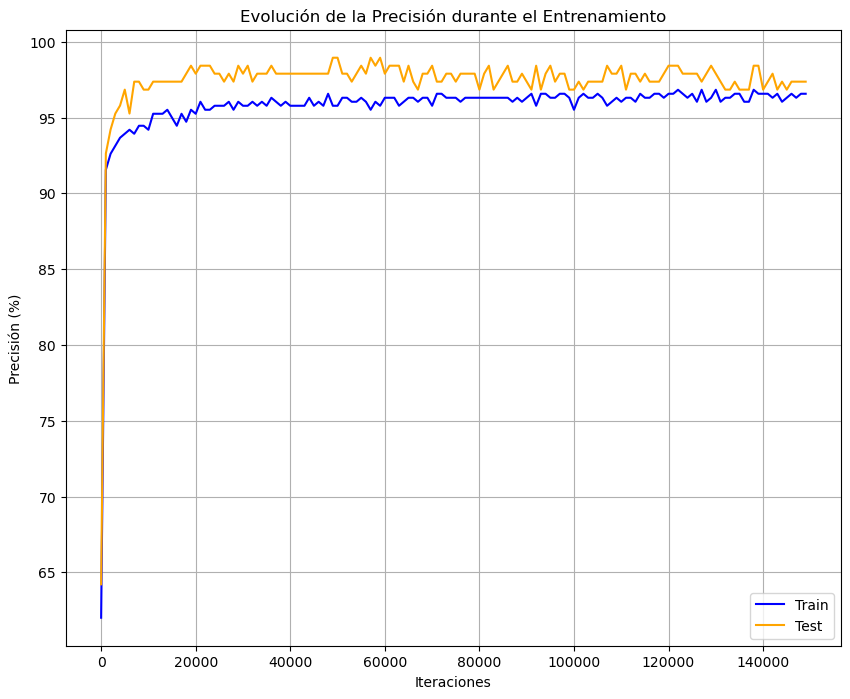

Post entrenamiento: 

Test
96.84210526315809
Train
96.30606860158363


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

# # Guarda el archivo en una variable
df2 = pd.read_csv('cancer_de_mama_limpio_top10.csv')

# Extraer variables de entrada (todas las filas, columnas de 2 a 10)
X = df2.iloc[:, 2:11].values

# Extraer columna de salida (todas las filas, columna 'diagnosis')
Y = df2.iloc[:, 1].values  

# Normalizar las características con StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en un conjunto de entrenamiento y uno de prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/3)

# Número de registros de entrenamiento
n = X_train.shape[0]
print('Cantidad de filas de entrenamiento: ', n)

# Funciones de activación
#d_leaky_relu = lambda x: np.where(x > 0, x, 0.01) 
relu = lambda x: np.maximum(x, 0)
logistic = lambda x: 1 / (1 + np.exp(-x))

# Semilla para reproducibilidad
np.random.seed(2)

# Construir red neuronal con pesos y sesgos
# inicializados aleatoriamente
w_hidden = (np.random.rand(3, 9) * 2) - 1  
w_output = (np.random.rand(1, 3) * 2) - 1  

b_hidden = (np.random.rand(3, 1) * 2) - 1  
b_output = (np.random.rand(1, 1) * 2) - 1  

# Funcion que corre la red neuronal con los datos de entrada para predecir la salida
def forward_prop(X):
    Z1 = w_hidden @ X + b_hidden        
    A1 = relu(Z1)
    Z2 = w_output @ A1 + b_output       
    A2 = logistic(Z2)
    return Z1, A1, Z2, A2

# Cálculo de precisión
def precision(X, Y):
    test_predictions = forward_prop(X.transpose())[3] # me interesa solo la capa de salida, A2
    test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), Y)
    accuracy = sum(test_comparisons.astype(int) / X.shape[0])
    return accuracy * 100

# Tasa de aprendizaje
L = 0.01

# Derivadas de las funciones de activación
d_leaky_relu = lambda x: x > 0
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

## Devuelve pendientes para pesos y sesgos
# usando la regla de la cadena
def backward_prop(Z1, A1, Z2, A2, X, Y):
    dC_dA2 = 2 * A2 - 2 * Y
    dA2_dZ2 = d_logistic(Z2)
    dZ2_dA1 = w_output
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dA1_dZ1 = d_leaky_relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    dC_dW2 = dC_dA2 @ dA2_dZ2 @ dZ2_dW2.T

    dC_dB2 = dC_dA2 @ dA2_dZ2 * dZ2_dB2

    dC_dA1 = dC_dA2 @ dA2_dZ2 @ dZ2_dA1

    dC_dW1 = dC_dA1 @ dA1_dZ1 @ dZ1_dW1.T

    dC_dB1 = dC_dA1 @ dA1_dZ1 * dZ1_dB1

    return dC_dW1, dC_dB1, dC_dW2, dC_dB2


# Listas para almacenar la precisión
train_accuracies = []
test_accuracies = []

# Ejecutar descenso de gradiente
for i in tqdm(range(150_000)):
    # seleccionar aleatoriamente uno de los datos de entrenamiento
    idx = np.random.choice(n, 1, replace=False)
    X_sample = X_train[idx].transpose()
    Y_sample = Y_train[idx]

    # pasar datos seleccionados aleatoriamente a través de la red neuronal
    Z1, A1, Z2, A2 = forward_prop(X_sample)
    
    # distribuir error a través de la retropropagación
    # y devolver pendientes para pesos y sesgos
    dW1, dB1, dW2, dB2 = backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample)
    
    # actualizar pesos y sesgos
    w_hidden -= L * dW1
    b_hidden -= L * dB1
    w_output -= L * dW2
    b_output -= L * dB2

    # Almacenar la precisión cada 1000 iteraciones
    if i % 1000 == 0:
        train_acc = precision(X_train, Y_train)
        test_acc = precision(X_test, Y_test)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

# Graficar la evolución de la precisión
plt.figure(figsize=(10, 8))
plt.plot(range(0, 150000, 1000), train_accuracies, label='Train', color='blue')
plt.plot(range(0, 150000, 1000), test_accuracies, label='Test', color='orange')
plt.title('Evolución de la Precisión durante el Entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Precisión (%)')
plt.legend()
plt.grid()
plt.show()

# Cálculo de precisión post-entrenamiento
print('Post entrenamiento: \n')
print('Test')
post_test_acc = precision(X_test, Y_test)
print(post_test_acc)
print('Train')
post_train_acc = precision(X_train, Y_train)
print(post_train_acc)